## What is a Time Series?
The basic object of forecasting is the time series, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

In [22]:
import pandas as pd
import numpy as np
df = pd.read_csv("./ts-course-data/book_sales.csv"
                ,index_col = "Date"
                ,parse_dates=['Date']
                ).drop("Paperback",axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


This series records the number of hardcover book sales at a retail store over 30 days. Notice that we have a single column of observations `Hardcover` with a time index `Date`.

## Linear Regression with Time Series
For the first part of this course, we'll use the linear regression algorithm to construct forecasting models. Linear regression is widely used in practice and adapts naturally to even complex forecasting tasks.

The **linear regression** algorithm learns how to make a weighted sum from its input features. For two features, we would have:

`target = weight_1 * feature_1 + weight_2 * feature_2 + bias`

### Time Step Features
* Time-Step features 
   * Features that can directly derived from the time index
   * Like the **time dummy**, which counts off tiem steps in the series from begin to end.

In [23]:
# the "Time" attribute is a time-step feature, a dummy feature
df["Time"] = np.arange(len(df.index))

df.head()


,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


/var/folders/k0/sqlrb6tx7w77mv29j7333kyh0000gq/T/ipykernel_12630/3325660717.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


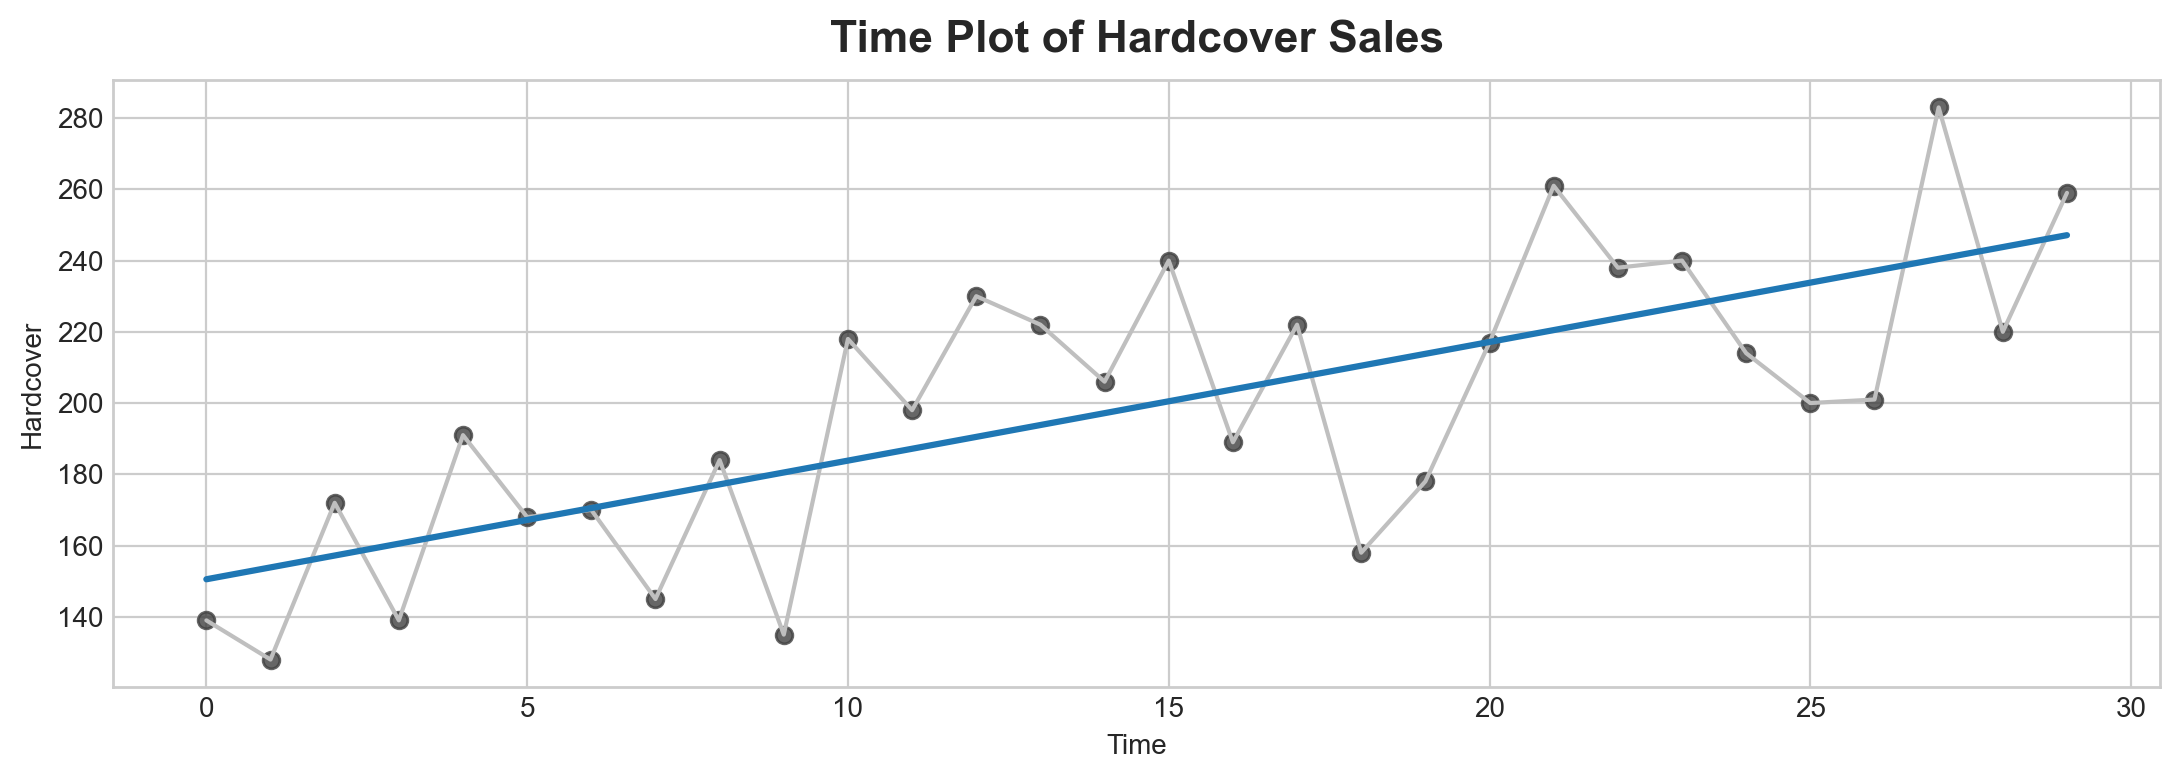

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc("figure"
       ,autolayout=True
       ,figsize=(11,4)
       ,titlesize=18
       ,titleweight='bold'
)
plt.rc("axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci = None,scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

### Lag Features 
To make a lag feature we **shift the observations of the target series so that they appear to have occured later in time.** Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [25]:
df["Lag_1"] = df["Hardcover"].shift(1)
df = df.reindex(columns = ["Hardcover","Lag_1"])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Linear regression with a lag feature produces the model:

`target = weight * lag + bias`

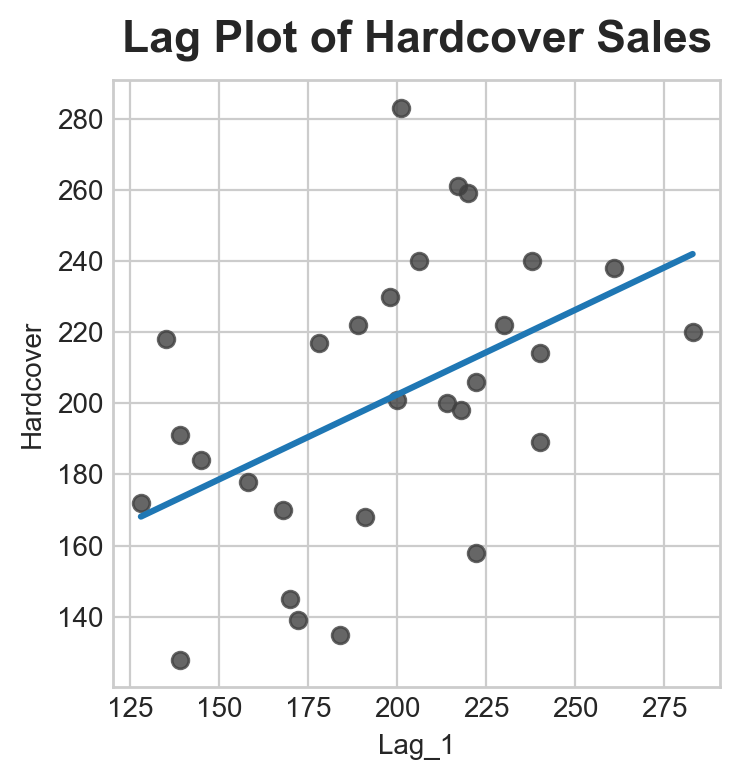

In [26]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

You can see from the lag plot that sales on one day (`Hardcover`) are correlated with sales from the previous day (`Lag_1`). When you see a relationship like this, you know a lag feature will be useful.

More generally, lag features let you model **serial dependence**. A time series has serial dependence when an observation can be predicted from previous observations. In Hardcover Sales, we can predict that high sales on one day usually mean high sales the next day.
****
Adapting machine learning algorithms to time series problems is largely about feature engineering with the time index and lags. For most of the course, we use linear regression for its simplicity, but these features will be useful whichever algorithm you choose for your forecasting task.

## Example - Tunnel Traffic
*Tunnel Traffic* is a time series describing the number of vehicles traveling through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005. In this example, we'll get some practice applying linear regression to time-step features and lag features.

The hidden cell sets everything up.

In [54]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("./ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [55]:
from sklearn.linear_model import LinearRegression

df = tunnel.copy()
df["Time"] = np.arange(len(tunnel.index))
# The procedure for fitting a linear regression model follows the standard steps for scikit-learn.
# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


The model actually created is (approximately):

`Vehicles = 22.5 * Time + 98176`

Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

Text(0.5, 1.0, 'Time Plot of Tunnel Traffic')

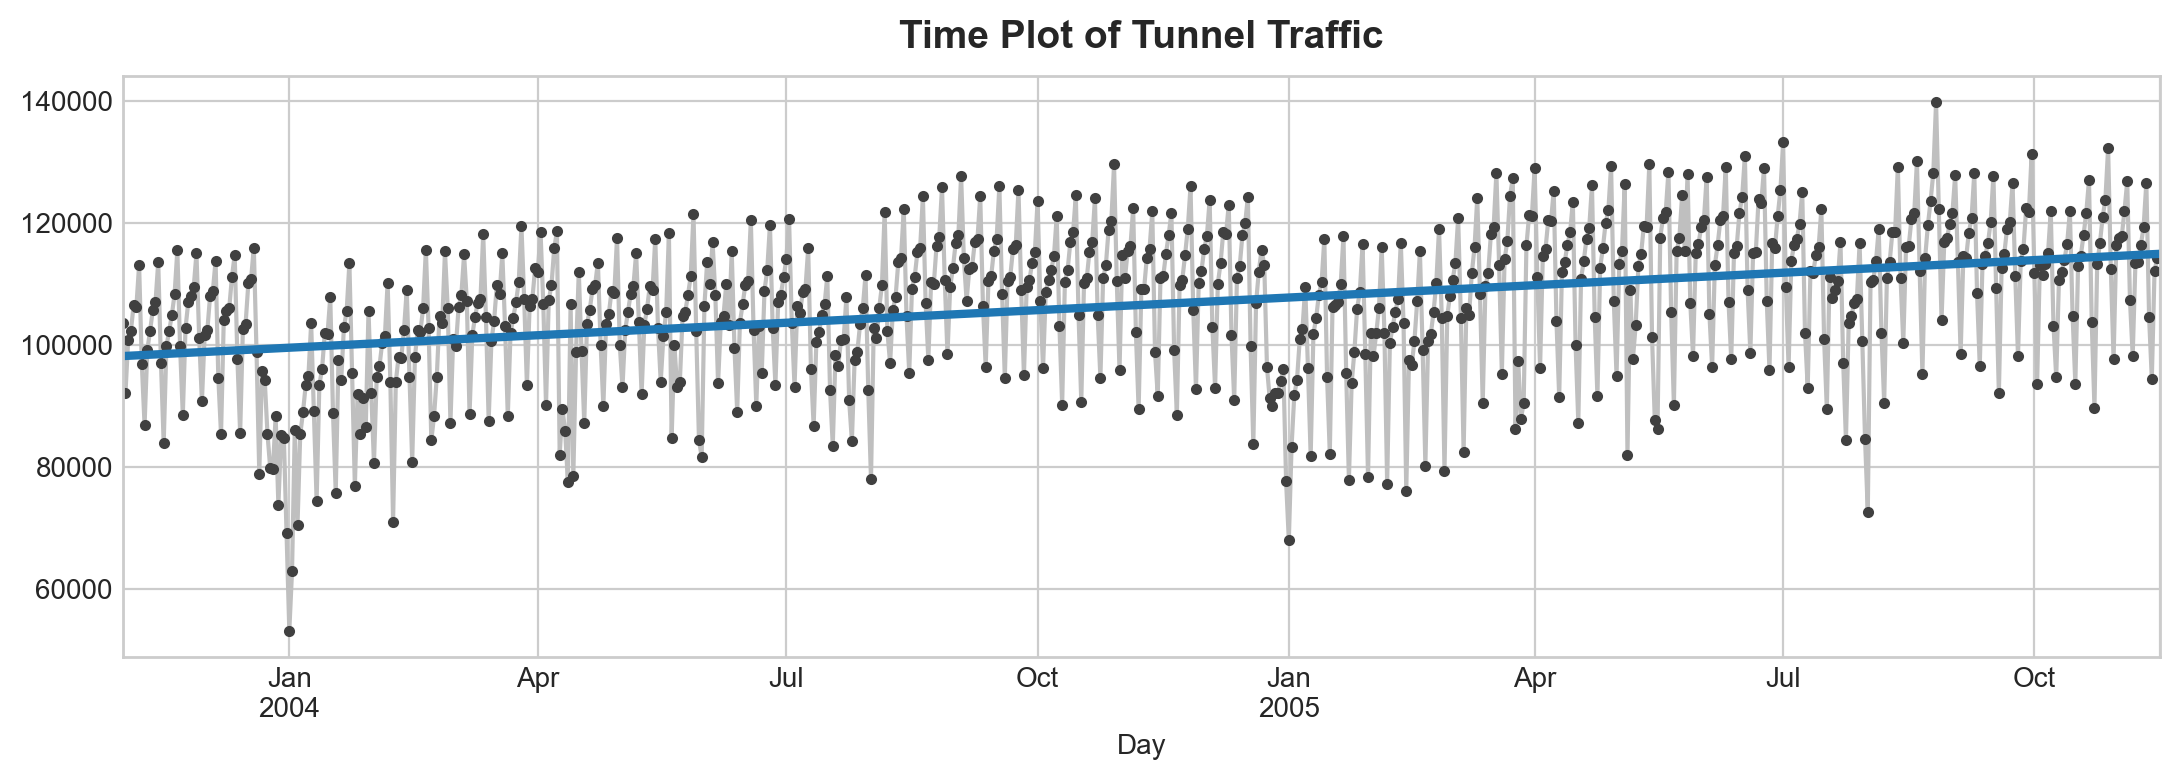

In [56]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax,linewidth=3)
ax.set_title("Time Plot of Tunnel Traffic")

In [59]:
# Create Lag Features 
df["Lag_1"] = df["NumVehicles"].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [83]:
from sklearn.linear_model import LinearRegression
X = df.loc[:,["Time"]]
X.dropna(inplace=True)
y = df.loc[:,"NumVehicles"]
y,X = y.align(X, join="inner")

model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X),index=X.index)
 

Text(0.5, 1.0, 'Time Plot of Tunnel Traffic')

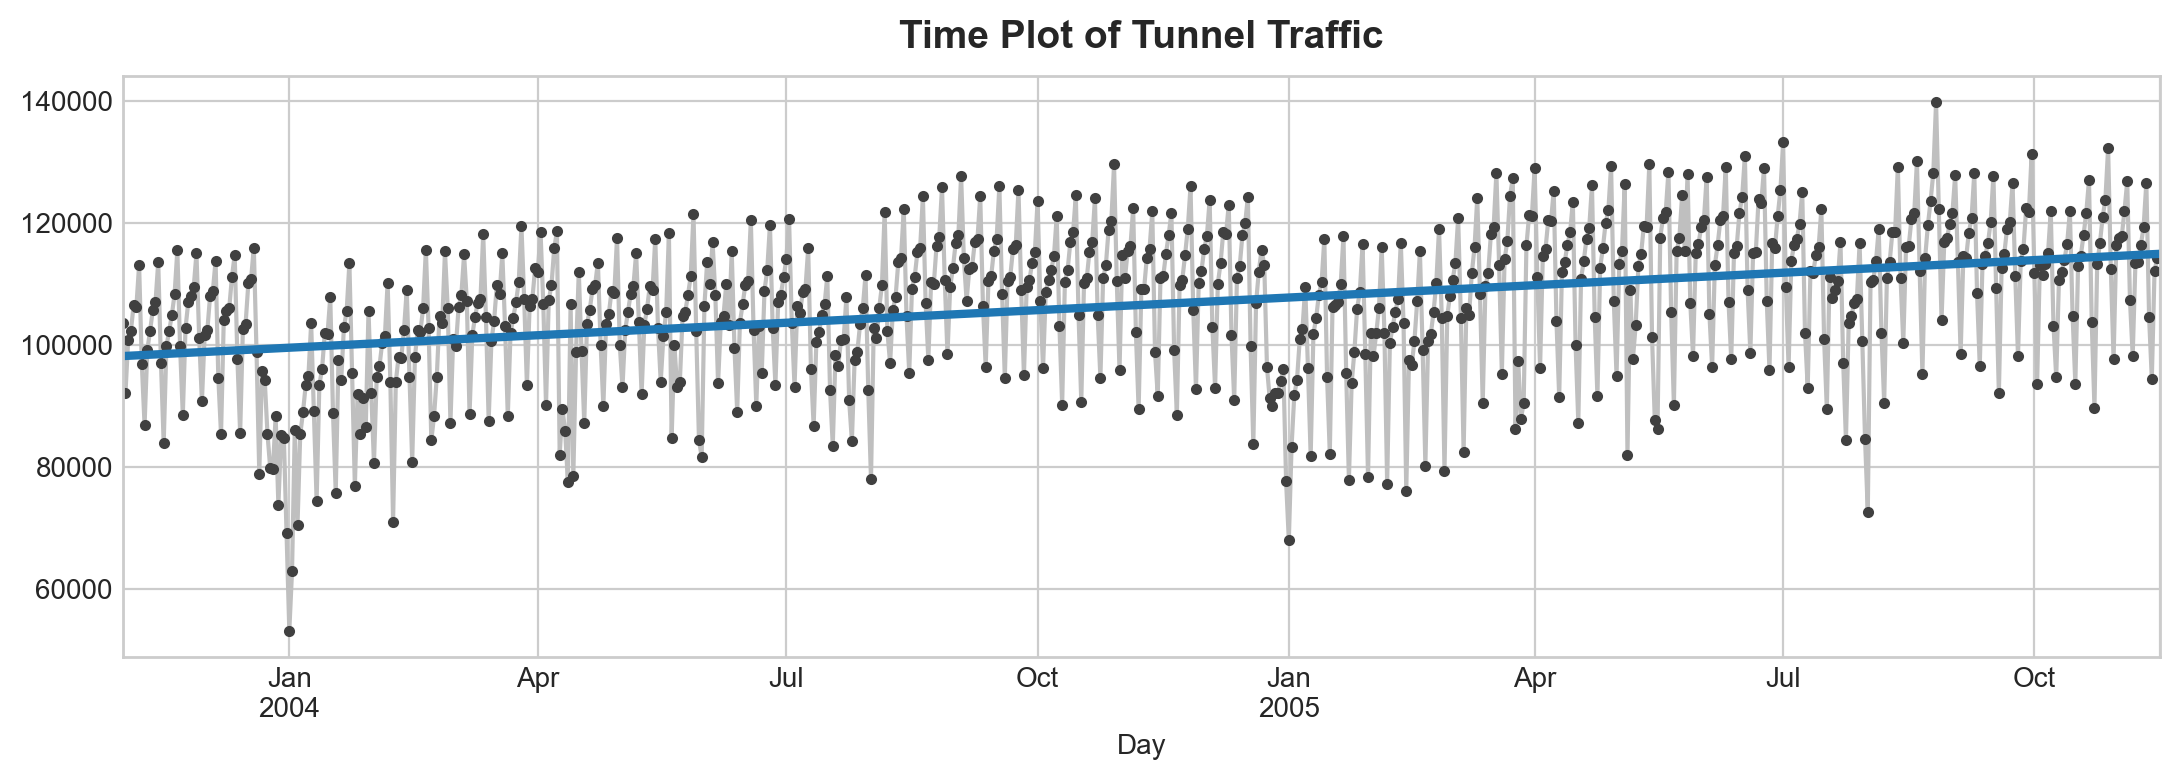

In [84]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax,linewidth=3)
ax.set_title("Time Plot of Tunnel Traffic")

### Lag Feature
Pandas provides us a simple method to lag a series, the `shift` method.

In [85]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [86]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

Text(0.5, 1.0, 'Lag Plot of Tunnel Traffic')

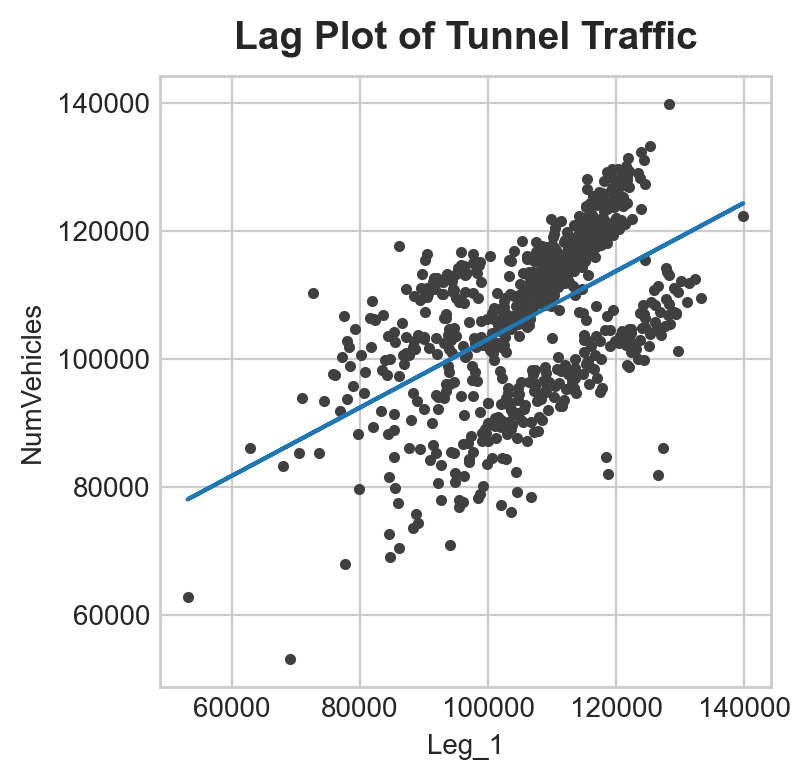

In [94]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'],y,'.',color='0.25')
ax.plot(X['Lag_1'],y_pred,'-')
ax.set_aspect("equal")
ax.set_ylabel("NumVehicles")
ax.set_xlabel("Leg_1")
ax.set_title("Lag Plot of Tunnel Traffic")